### Installation & Import

In [ ]:
# Restart runtime
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 8.3 MB/s eta 0

In [ ]:
# import
import pandas as pd
from glob import glob
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 소프트링크
!ln -s /content/drive/MyDrive/Colab\ Notebooks/DACON/dacon-lettuce-generative /mydrive
!ls /mydrive

AutoGluon     CTGAN.ipynb  lstm.ipynb	open.zip  synthetic_data  vae.ipynb
code_example  EDA.ipynb    model_param	results   terminal.ipynb


In [ ]:
# 압축풀기
!mkdir /content/dataset
!cd /mydrive; unzip open.zip -d /content/dataset

Archive:  open.zip
  inflating: /content/dataset/sample_submission.zip  
   creating: /content/dataset/test_input/
  inflating: /content/dataset/test_input/TEST_01.csv  
  inflating: /content/dataset/test_input/TEST_02.csv  
  inflating: /content/dataset/test_input/TEST_03.csv  
  inflating: /content/dataset/test_input/TEST_04.csv  
  inflating: /content/dataset/test_input/TEST_05.csv  
   creating: /content/dataset/test_target/
  inflating: /content/dataset/test_target/TEST_01.csv  
  inflating: /content/dataset/test_target/TEST_02.csv  
  inflating: /content/dataset/test_target/TEST_03.csv  
  inflating: /content/dataset/test_target/TEST_04.csv  
  inflating: /content/dataset/test_target/TEST_05.csv  
   creating: /content/dataset/train_input/
  inflating: /content/dataset/train_input/CASE_01.csv  
  inflating: /content/dataset/train_input/CASE_02.csv  
  inflating: /content/dataset/train_input/CASE_03.csv  
  inflating: /content/dataset/train_input/CASE_04.csv  
  inflating: /conten

In [ ]:
!ls -lia /content/dataset

total 28
5112277 drwxr-xr-x 6 root root 4096 Sep 15 12:08 .
4063238 drwxr-xr-x 1 root root 4096 Sep 15 12:08 ..
5112290 -rw-r--r-- 1 root root 1142 Nov 21  2022 sample_submission.zip
5112300 drwxr-xr-x 2 root root 4096 Nov 20  2022 test_input
5112334 drwxr-xr-x 2 root root 4096 Nov 21  2022 test_target
5112344 drwxr-xr-x 2 root root 4096 Nov 20  2022 train_input
5112373 drwxr-xr-x 2 root root 4096 Nov 20  2022 train_target


### Data Load & Preprocessing

In [ ]:
# data load & preprocessing
def make_dataset(input_dir_list, target_dir_list):
  input_all = pd.DataFrame()
  target_all = pd.DataFrame()
  for i in range(len(input_dir_list)):
    input_df = pd.read_csv(input_dir_list[i])
    target_df = pd.read_csv(target_dir_list[i])
    input_df['Case'] = i + 1
    target_df['Case'] = i + 1
    input_all = pd.concat([input_all, input_df])
    target_all = pd.concat([target_all, target_df])
  input_all['obs_time'] = pd.to_datetime(input_all['obs_time'])
  input_all['obs_time'] = input_all['obs_time'].dt.hour

  # 이상값 처리
  # 내부온도,습도=0 -> 평균으로 대체
  # print(round(input_all[(input_all['DAT'] == 0) & (input_all['obs_time'] == 15) & (input_all['Case'] != 4)]['내부온도관측치'].mean(), 6))
  # print(round(input_all[(input_all['DAT'] == 0) & (input_all['obs_time'] == 15) & (input_all['Case'] != 4)]['내부습도관측치'].mean(), 6))
  input_all.loc[input_all['내부온도관측치'] == 0, '내부온도관측치'] = 28.479124
  input_all.loc[input_all['내부습도관측치'] == 0, '내부습도관측치'] = 53.469956

  # 시간당분무량<0 -> 0으로 대체
  input_all.loc[input_all['시간당분무량'] < 0, '시간당분무량'] = 0

  # 시간당백색,적색,청색광량<0 -> 최빈값으로 대체
  # print(input_all.loc[input_all['시간당백색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(input_all.loc[input_all['시간당적색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(input_all.loc[input_all['시간당청색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(input_all[(input_all['DAT'] == 0) & (input_all['obs_time'] == 15) & (input_all['Case'] != 6)]['시간당백색광량'].mode())
  # print(input_all[(input_all['DAT'] == 0) & (input_all['obs_time'] == 15) & (input_all['Case'] != 6)]['시간당적색광량'].mode())
  # print(input_all[(input_all['DAT'] == 0) & (input_all['obs_time'] == 15) & (input_all['Case'] != 6)]['시간당청색광량'].mode())
  input_all.loc[input_all['시간당백색광량'] < 0, '시간당백색광량'] = 18255.19
  input_all.loc[input_all['시간당적색광량'] < 0, '시간당적색광량'] = 0
  input_all.loc[input_all['시간당청색광량'] < 0, '시간당청색광량'] = 0

  # 새로운 feature 생성
  input_all['온습도'] = input_all['내부온도관측치'] * input_all['내부습도관측치']
  input_all['온도co2'] = input_all['내부온도관측치'] * input_all['co2관측치']
  input_all['습도co2'] = input_all['내부습도관측치'] * input_all['내부습도관측치']
  input_all['온습도co2'] = input_all['내부온도관측치'] * input_all['내부습도관측치'] * input_all['co2관측치']
  input_all['광량여부'] = (input_all['시간당백색광량'] + input_all['시간당적색광량'] + input_all['시간당청색광량']).map(lambda x: 0 if x == 0 else 1)

  # 누적, 시간당총광량 column 삭제
  col_names = input_all.columns
  drop_feature_list = ['DAT', 'obs_time', 'Case', '시간당총광량']
  for col in col_names:
    if '누적' in col or col in drop_feature_list:
      input_all = input_all.drop(col, axis=1)

  # 시간별 데이터 -> 일별 데이터
  input_list = []
  target_list = []

  for i in range(target_all.shape[0]):
    day_data = input_all[24*i:24*(i+1)]
    time_series = day_data.values.flatten().tolist() + [i%28]
    input_list.append(time_series)

  for target in target_all['predicted_weight_g']:
    target_list.append(target)

  all_col = []
  for hour in range(24):
    for col in input_all.columns:
      all_col.append(f'{hour}시_{col}')
  all_col.append('day')

  input = pd.DataFrame(input_list, columns=all_col)
  target = pd.DataFrame(target_list, columns=['predicted_weight_g'])

  return input, target

In [ ]:
train_input_dir = sorted(glob('/content/dataset/train_input/*.csv'))
train_target_dir = sorted(glob('/content/dataset/train_target/*.csv'))
test_input_dir = sorted(glob('/content/dataset/test_input/*.csv'))
test_target_dir = sorted(glob('/content/dataset/test_target/*.csv'))

train_input, train_target = make_dataset(train_input_dir, train_target_dir)
test_input, test_target = make_dataset(test_input_dir, test_target_dir)

In [ ]:
# StandardScaler()
scaler = StandardScaler()
train_input_scaled = pd.DataFrame(scaler.fit_transform(train_input), columns=train_input.columns)
test_input_scaled = pd.DataFrame(scaler.transform(test_input), columns=test_input.columns)

In [ ]:
# modify target; 중량 증가분
def modify_target(target):
  new_target = []
  target_ = target.values.flatten()
  for idx in range(len(target_)):
    if idx % 28 == 0:
      new_target.append(target_[idx])
    else:
      delta_label = target_[idx] - target_[idx-1]
      new_target.append(delta_label)
  new_target = pd.DataFrame(new_target, columns=target.columns)
  return new_target

modified_target = modify_target(train_target)

### Modeling

0. Unscaled train data

In [ ]:
train = pd.concat([train_input, train_target], axis=1)
train_data = TabularDataset(train)
test_data = TabularDataset(test_input)

!mkdir /mydrive/results
!mkdir /mydrive/results/exp_0
savedir = '/mydrive/results/exp_0'

predictor = TabularPredictor(label='predicted_weight_g', eval_metric='root_mean_squared_error', path=savedir).fit(train_data, presets='high_quality',  ag_args_fit={'num_gpus': 0})


mkdir: cannot create directory ‘/mydrive/results’: File exists
mkdir: cannot create directory ‘/mydrive/results/exp_0’: File exists


Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=7, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "/mydrive/results/exp_0/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   4.50 GB / 16.11 GB (27.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    784
Train Data Columns: 313
Label Column: predicted_weight_g
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (164.150299846821, 0.167719388078703, 34.91968, 41.60575)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify probl

In [ ]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -7.222961       1.131994  47.007820                0.000427           0.067829            3       True          8
1          ExtraTreesMSE_BAG_L2  -7.227856       1.032722  29.114788                0.105374           4.153340            2       True          7
2        RandomForestMSE_BAG_L2  -7.546155       1.026192  42.786651                0.098845          17.825204            2       True          6
3          ExtraTreesMSE_BAG_L1  -8.997346       0.284945   6.083835                0.284945           6.083835            1       True          4
4           WeightedEnsemble_L2  -8.997346       0.285359   6.207108                0.000414           0.123272            2       True          5
5        RandomForestMSE_BAG_L1 -10.761364       0.46830

In [ ]:
lboard = predictor.leaderboard()

                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -7.222961       1.131994  47.007820                0.000427           0.067829            3       True          8
1          ExtraTreesMSE_BAG_L2  -7.227856       1.032722  29.114788                0.105374           4.153340            2       True          7
2        RandomForestMSE_BAG_L2  -7.546155       1.026192  42.786651                0.098845          17.825204            2       True          6
3          ExtraTreesMSE_BAG_L1  -8.997346       0.284945   6.083835                0.284945           6.083835            1       True          4
4           WeightedEnsemble_L2  -8.997346       0.285359   6.207108                0.000414           0.123272            2       True          5
5        RandomForestMSE_BAG_L1 -10.761364       0.468308  18.782023                0.468308          18.782023       

In [ ]:
# Predict test data
y_pred = predictor.predict(test_data)
y_pred = pd.DataFrame(y_pred, columns=['predicted_weight_g'])
y_pred

,predicted_weight_g
0,0.656317
1,1.195148
2,2.025732
3,2.157568
4,1.949686
...,...
135,58.237938
136,78.642479
137,87.599602
138,91.071716


In [ ]:
# 실제값, 예측값 비교 시각화

def true_pred(train_df, predict_model, n_cases=5):
  pred_df = predict_model.predict(train_df.iloc[:28*n, :-1])
  pred_df = pd.DataFrame(pred_df, columns=['predicted_weight_g'])

  true_val = pd.DataFrame()
  pred_val = pd.DataFrame()
  colnames = []
  for i in range(n_cases):
    colnames.append(f'case{i+1}')
    true = train_df.iloc[i*28:(i+1)*28, [-1]].reset_index(drop=True)
    pred = pred_df.iloc[i*28:(i+1)*28, [-1]].reset_index(drop=True)
    true_val = pd.concat([true_val, true], axis=1)
    pred_val = pd.concat([pred_val, pred], axis=1)
  true_val.columns = colnames
  pred_val.columns = colnames
  return true_val, pred_val

def visualize_pred(true, pred, n):
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
  ax = ax.flatten()
  for i in range(n):
    ax[i].set_title(f'case{i+1}')
    ax[i].plot(true[f'case{i+1}'], 'r-', label='true')
    ax[i].plot(pred[f'case{i+1}'], 'b--', label='pred')
    ax[i].legend()

  plt.suptitle('True vs Pred')
  fig.tight_layout()
  plt.show()


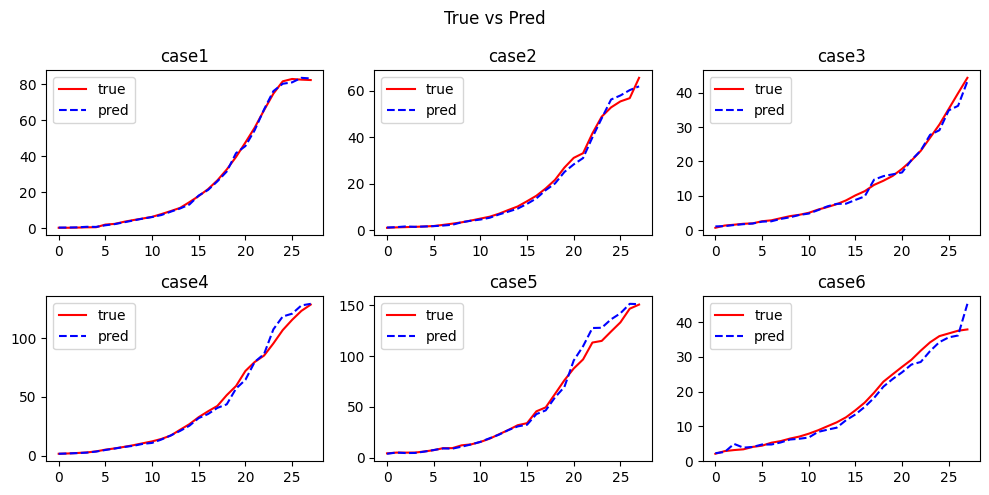

In [ ]:
n = 6
true, pred = true_pred(train_data, predictor, n_cases=n)
visualize_pred(true, pred, n)

In [ ]:
# Evaluation
eval_score = predictor.evaluate(train_data)

Evaluation: root_mean_squared_error on test data: -2.613764909128602
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -2.613764909128602,
    "mean_squared_error": -6.831767000192048,
    "mean_absolute_error": -1.482255752251141,
    "r2": 0.9960483305102088,
    "pearsonr": 0.9983816344943647,
    "median_absolute_error": -0.6427971465190849
}


1. 데이터 스케일링

In [ ]:
train_scaled = pd.concat([train_input_scaled, train_target], axis=1)
train_data_scaled = TabularDataset(train_scaled)
test_data_scaled = TabularDataset(test_input_scaled)

!mkdir /mydrive/results/exp_1
savedir = '/mydrive/results/exp_1'

predictor2 = TabularPredictor(label='predicted_weight_g', eval_metric='root_mean_squared_error', path=savedir).fit(train_data_scaled, presets='high_quality',  ag_args_fit={'num_gpus': 0})


Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=7, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "/mydrive/results/exp_1/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   4.34 GB / 16.11 GB (26.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    784
Train Data Columns: 313
Label Column: predicted_weight_g
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (164.150299846821, 0.167719388078703, 34.91968, 41.60575)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify probl

In [ ]:
results2 = predictor2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -7.097343       0.808993  60.392022                0.000524           0.412100            3       True          8
1          ExtraTreesMSE_BAG_L2  -7.105635       0.630336  38.337781                0.390096          15.628103            2       True          7
2        RandomForestMSE_BAG_L2  -7.527814       0.418373  44.351819                0.178133          21.642141            2       True          6
3           WeightedEnsemble_L2  -8.979185       0.121001   4.147663                0.000433           0.116723            2       True          5
4          ExtraTreesMSE_BAG_L1  -8.997687       0.106504   4.003677                0.106504           4.003677            1       True          4
5        RandomForestMSE_BAG_L1 -10.749393       0.10390

In [ ]:
lboard2 = predictor2.leaderboard()

                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -7.097343       0.808993  60.392022                0.000524           0.412100            3       True          8
1          ExtraTreesMSE_BAG_L2  -7.105635       0.630336  38.337781                0.390096          15.628103            2       True          7
2        RandomForestMSE_BAG_L2  -7.527814       0.418373  44.351819                0.178133          21.642141            2       True          6
3           WeightedEnsemble_L2  -8.979185       0.121001   4.147663                0.000433           0.116723            2       True          5
4          ExtraTreesMSE_BAG_L1  -8.997687       0.106504   4.003677                0.106504           4.003677            1       True          4
5        RandomForestMSE_BAG_L1 -10.749393       0.103909  18.651523                0.103909          18.651523       

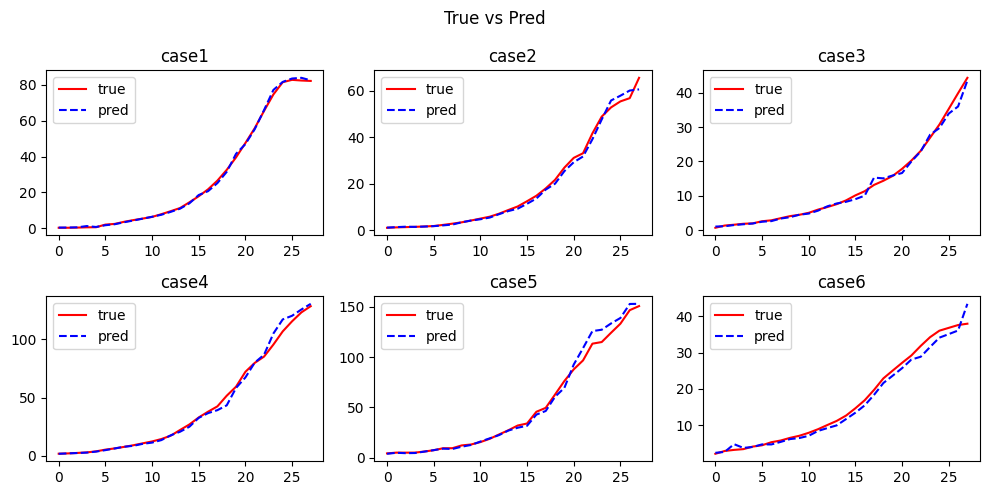

In [ ]:
n = 6
true2, pred2 = true_pred(train_data_scaled, predictor2, n_cases=n)
visualize_pred(true2, pred2, n)

In [ ]:
# Evaluation
eval_score2 = predictor2.evaluate(train_data_scaled)

Evaluation: root_mean_squared_error on test data: -2.458734430809917
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -2.458734430809917,
    "mean_squared_error": -6.045375001250166,
    "mean_absolute_error": -1.4373880488705368,
    "r2": 0.9965031998389121,
    "pearsonr": 0.9985818447424606,
    "median_absolute_error": -0.63979658126831
}


In [ ]:
# Predict test data
y_pred2 = predictor2.predict(test_data_scaled)
y_pred2 = pd.DataFrame(y_pred2, columns=['predicted_weight_g'])
y_pred2

,predicted_weight_g
0,0.627500
1,1.027556
2,2.067629
3,2.086314
4,2.160510
...,...
135,59.761356
136,78.742287
137,87.749344
138,90.752800


2. 데이터 스케일링 + modify target; 중량 증가분

In [ ]:
train_scaled_ = pd.concat([train_input_scaled, modified_target], axis=1)
train_data_scaled_ = TabularDataset(train_scaled_)
test_data_scaled = TabularDataset(test_input_scaled)

!mkdir /mydrive/results/exp_2
savedir = '/mydrive/results/exp_2'

predictor3 = TabularPredictor(label='predicted_weight_g', eval_metric='root_mean_squared_error', path=savedir).fit(train_data_scaled_, presets='high_quality',  ag_args_fit={'num_gpus': 0})


Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=7, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "/mydrive/results/exp_2/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   4.26 GB / 16.11 GB (26.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    784
Train Data Columns: 313
Label Column: predicted_weight_g
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (24.00818624568059, -1.2393776480321037, 3.51941, 3.80155)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify prob

In [ ]:
results3 = predictor3.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -2.397654       1.016481  57.977735                0.000673           0.113996            3       True          8
1          ExtraTreesMSE_BAG_L2  -2.398351       0.903460  36.632508                0.167597           6.084538            2       True          7
2           WeightedEnsemble_L2  -2.419473       0.736369  30.664499                0.000506           0.116529            2       True          5
3          ExtraTreesMSE_BAG_L1  -2.435733       0.100133   7.003884                0.100133           7.003884            1       True          4
4        RandomForestMSE_BAG_L2  -2.453642       0.848211  51.779202                0.112349          21.231232            2       True          6
5        RandomForestMSE_BAG_L1  -2.501359       0.35034

In [ ]:
lboard3 = predictor3.leaderboard()

                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -2.397654       1.016481  57.977735                0.000673           0.113996            3       True          8
1          ExtraTreesMSE_BAG_L2  -2.398351       0.903460  36.632508                0.167597           6.084538            2       True          7
2           WeightedEnsemble_L2  -2.419473       0.736369  30.664499                0.000506           0.116529            2       True          5
3          ExtraTreesMSE_BAG_L1  -2.435733       0.100133   7.003884                0.100133           7.003884            1       True          4
4        RandomForestMSE_BAG_L2  -2.453642       0.848211  51.779202                0.112349          21.231232            2       True          6
5        RandomForestMSE_BAG_L1  -2.501359       0.350347  23.474968                0.350347          23.474968       

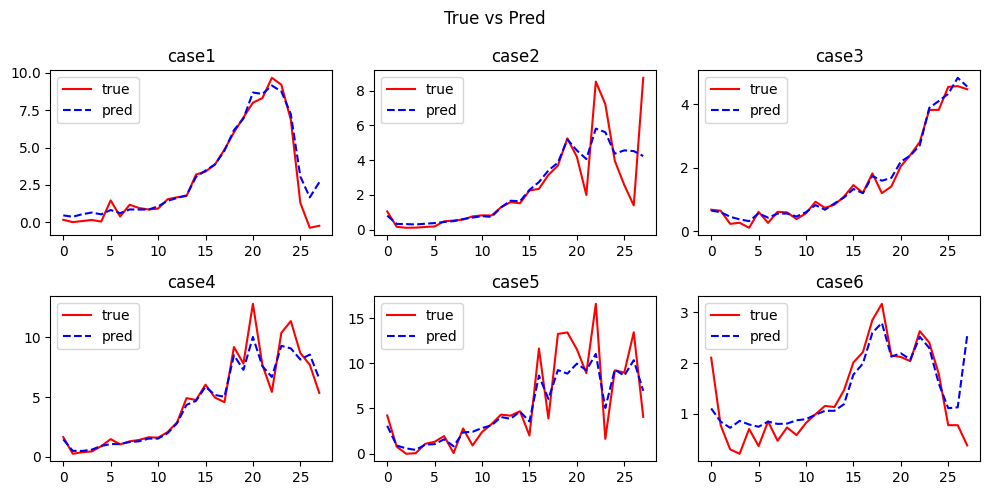

In [ ]:
n = 6
true3, pred3 = true_pred(train_data_scaled_, predictor3, n_cases=n)
visualize_pred(true3, pred3, n)

In [ ]:
# Evaluation
eval_score3 = predictor3.evaluate(train_data_scaled_)

Evaluation: root_mean_squared_error on test data: -1.3002301432512602
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -1.3002301432512602,
    "mean_squared_error": -1.6905984254191926,
    "mean_absolute_error": -0.680612938039372,
    "r2": 0.8828686916784265,
    "pearsonr": 0.9443182195764985,
    "median_absolute_error": -0.2657588390233032
}


In [ ]:
# Predict test data
y_pred3 = predictor3.predict(test_data_scaled)
y_pred3 = pd.DataFrame(y_pred3, columns=['predicted_weight_g'])
y_pred3

,predicted_weight_g
0,0.478821
1,0.552915
2,0.601986
3,0.649977
4,0.626600
...,...
135,6.615811
136,8.206599
137,9.296935
138,6.538521


In [ ]:
def restore_pred(pred):
  n = int(pred.shape[0]/28)
  pred_cum = pd.DataFrame()
  for i in range(n):
    pred_cumsum = pred.iloc[i*28:(i+1)*28, [-1]].cumsum()
    pred_cum = pd.concat([pred_cum, pred_cumsum], axis=0)
  return pred_cum


In [ ]:
restore_pred(y_pred3)

,predicted_weight_g
0,0.478821
1,1.031736
2,1.633722
3,2.283699
4,2.910299
...,...
135,59.145691
136,67.352287
137,76.649223
138,83.187744
